# DHIS2 - Tuning HDBSCAN parameters and running clustering

# Inputs
- Absolute path to the directory with .csv files
- Absolute path to the shapefile for your geography

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [1]:
import os
import re
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [2]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/ces_2006_2016'
GEO_LEVEL = 'districts'
PROJECT = "CES Data 10 Years "

In [3]:
def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/gdata_unicef_ces*")
    return input_files


def read_data(files_list, common=True):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file, encoding='cp850')
        data_dict[file].rename(columns={'Survey.Units"':'geo'}, inplace=True)
        subset = [not bool(re.search(r"Division|Launch District|CC|KCC|RCC|DCC|SCC|CCC|BCC|Urban|Rural|CC Slum| Slum|National", geo)) for geo in data_dict[file]['Survey.Units']]
        print(Counter([not bool(re.search(r"Division|Launch District|CC|KCC|RCC|DCC|SCC|CCC|BCC|Urban|Rural|CC Slum| Slum|National", geo)) for geo in data_dict[file]['Survey.Units']]))
        data_dict[file] = data_dict[file].loc[subset,:]
        print(data_dict[file].shape)
    return data_dict

def subset_vars(ddict):
    cols_list = []
    for key, value in ddict.items():
        print(value.columns)
        print(value.shape)
        cols_list.append(list(value.columns))
    cols_list = set(cols_list[0]).intersection(*cols_list)
    for key, value in ddict.items():
        ddict[key] = ddict[key].loc[:,cols_list]
        print(ddict[key].columns)
        print(ddict[key].shape)
        print("#"*100)
    return ddict

def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-8:-4])
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    out['Survey.Units'] = out['Survey.Units'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-8:-4])
        df['year'] = key[-8:-4]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    try:
        os.mkdir(os.path.split(output_dir)[1])
    except FileExistsError:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, 
                     output, cluster_selection_method, 
                     fmin_samples, fmin_cluster_size,
                     prune=False, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    geo = input_df['geo']
    input_df = input_df.drop('geo', axis=1)
    df = input_df.copy(deep=True)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), 
                                min_cluster_size=int(iteration[1]), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[1]
        models.loc[counter, 'min_samples'] = iteration[0]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        counter += 1
    if prune:
        out_model = hdbscan.HDBSCAN(min_samples=int(fmin_samples), 
                                min_cluster_size=int(fmin_cluster_size), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)

    else:
        out_model = None
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()
    del(input_df, df)
    return models, out_model


def cluster_data(input_df, f_min_samples, f_min_cluster_size, cluster_selection_method):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    print(cluster_data.columns)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best', 
                           cluster_selection_method=cluster_selection_method).fit(cluster_data)
    print(Counter(model.labels_))
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class', 'colors'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            print(variable)
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out


def update_geo1(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    display(geodata.head())
    display(df.head())
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    print(df.shape)
    df = df.drop(['dv', 'Div_Name', 'zl', 'Zila_Name2', 'geo'], axis=1)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df


def update_geo2(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df

def imput_missing(input_df):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if df[var].dtype != 'object':
            if df[var].isna().value_counts()[0]/df[var].shape[0] != 1.:
                tmp = df[var].fillna(np.mean(df[var]))
                df = df.drop(var,axis=1)
                df[var] = tmp
    return df


def output_class(input_df):
    df = input_df.copy(deep=True)
    out = list()
    for geo_var in df['geo'].unique():
        tmp = df[df['geo'] == geo_var]
        tmp = tmp[['geo','year', 'class']]
        tmp = tmp.pivot(index='geo', columns='year', values='class')
        tmp.reset_index(inplace=True)
        out.append(tmp)
    output = pd.concat(out, axis=0)
    output = output.reset_index(drop=True)
    return output

def output_table(input_df, out, name):
    df = input_df.copy(deep=True)
    remove = ['geo','year','colors']
    columns = df.columns
    variables = list(set(columns).difference(set(remove)))
    print(variables)
    out_min = df[variables].groupby('class').min().round(4)
    out_max = df[variables].groupby('class').max().round(4)
    out_mean = df[variables].groupby('class').mean().round(1)
    t = out_min.astype(str).add(' - ').add(out_mean.astype(str))
    t = t.astype(str).add(' - ').add(out_max.astype(str))
    t.to_csv(out+"/"+name+".csv", index_label=False)
    return t


## PART 1: Fine-tuning the clustering model
### STEP 1: Get files list

In [4]:
dfiles = get_files_list(input_dir=DATA)
dfiles = ['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2016.csv',
          '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2006.csv',]


### STEP 2: Read data

In [5]:
ddata = read_data(files_list=dfiles)

Counter({True: 64, False: 24})
(64, 52)
Counter({True: 64, False: 13})
(64, 36)


In [6]:
ddata = subset_vars(ddict=ddata)

Index(['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
       'FuzzRatio', 'Geo', 'Survey.Units', 'BCG_Children23M',
       'OPV1_Children23M', 'PENTA1_Children23M', 'OPV2_Children23M',
       'PENTA2_Children23M', 'OPV3_Children23M', 'PENTA3_Children23M',
       'Measles_Children23M', 'Fully_Children23M', 'BCG_Children12M',
       'OPV1_Children12M', 'PENTA1_Children12M', 'OPV2_Children12M',
       'PENTA2_Children12M', 'OPV3_Children12M', 'PENTA3_Children12M',
       'Measles_Children12M', 'Fully_Children12M',
       'DropoutPENTA1-PENTA3_Male23M', 'DropoutPENTA1-PENTA3_Female23M',
       'DropoutPENTA1-PENTA3_Children23M', 'DropoutPENTA1-Measles_Male23M',
       'DropoutPENTA1-Measles_Female23M', 'DropoutPENTA1-Measles_Children23M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'InvalidMeasles_Infant12M',
       'Measles2ndDoseCrude', 'Measles2ndDose_Children18M',
       'Measles2ndDose_Children23M', 'TT1_Mother0-11MCh

### STEP 3: Check data 

In [7]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP 4: Concat data 

In [8]:
ddf = concat_data1(ddict=ddata)

2016
2006


In [9]:
ddf.head()

,BCG_Children12M,DistrictCode,DistrictName,DivisionCode,DivisionName,Fully_Children12M,FuzzRatio,Geo,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,Survey.Units,VitACoverage_Children12-59M,Year
0,98.2,1,Bagerhat,40,Khulna,86.8,94,Bagerhat,90.3,97.4,96.8,90.8,Bagerhat 2016,82.0,2016
1,99.0,3,Bandarban,20,Chittagong,80.9,95,Bandarban,86.3,96.3,94.8,87.8,Bandarban 2016,84.1,2016
2,99.7,4,Barguna,10,Barisal,87.6,93,Barguna,91.0,98.8,97.9,93.0,Barguna 2016,96.8,2016
3,99.7,6,Barisal,10,Barisal,91.0,93,Barisal,93.1,99.1,99.3,95.5,Barisal 2016,100.0,2016
6,99.8,9,Bhola,10,Barisal,91.3,91,Bhola,95.4,99.8,99.8,94.5,Bhola 2016,98.4,2016


### STEP 5: Create output dir

In [10]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


### STEP 6: Data and geo clean up child health data

In [11]:
ddf['DistrictCode'] = ddf['DistrictCode'].astype(str)
ddf['DivisionCode'] = ddf['DivisionCode'].astype(str)
ddf['DistrictCode'] = ddf['DistrictCode'].str.pad(width=2, side='left', fillchar='0')
ddf['DivisionCode'] = ddf['DivisionCode'].str.pad(width=2, side='left', fillchar='0')
print(Counter([len(string) for string in ddf['DistrictCode']]))
print(Counter([len(string) for string in ddf['DivisionCode']]))
ddf['geo'] = ddf['DivisionCode'].str.cat(ddf['DistrictCode'])
display(ddf.head())
print(ddf.columns)

Counter({2: 128})
Counter({2: 128})


,BCG_Children12M,DistrictCode,DistrictName,DivisionCode,DivisionName,Fully_Children12M,FuzzRatio,Geo,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,Survey.Units,VitACoverage_Children12-59M,Year,geo
0,98.2,01,Bagerhat,40,Khulna,86.8,94,Bagerhat,90.3,97.4,96.8,90.8,Bagerhat 2016,82.0,2016,4001
1,99.0,03,Bandarban,20,Chittagong,80.9,95,Bandarban,86.3,96.3,94.8,87.8,Bandarban 2016,84.1,2016,2003
2,99.7,04,Barguna,10,Barisal,87.6,93,Barguna,91.0,98.8,97.9,93.0,Barguna 2016,96.8,2016,1004
3,99.7,06,Barisal,10,Barisal,91.0,93,Barisal,93.1,99.1,99.3,95.5,Barisal 2016,100.0,2016,1006
6,99.8,09,Bhola,10,Barisal,91.3,91,Bhola,95.4,99.8,99.8,94.5,Bhola 2016,98.4,2016,1009


Index(['BCG_Children12M', 'DistrictCode', 'DistrictName', 'DivisionCode',
       'DivisionName', 'Fully_Children12M', 'FuzzRatio', 'Geo',
       'Measles_Children12M', 'OPV1_Children12M', 'OPV2_Children12M',
       'OPV3_Children12M', 'Survey.Units', 'VitACoverage_Children12-59M',
       'Year', 'geo'],
      dtype='object')


In [12]:
immunisation_drop = ['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
                     'FuzzRatio', 'Geo', 'Year', 'Survey.Units', ]
immunisation_data = ddf.drop(immunisation_drop, axis=1)
immunisation_data.head()


,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,geo
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,4001
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2003
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,1004
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,1006
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,1009


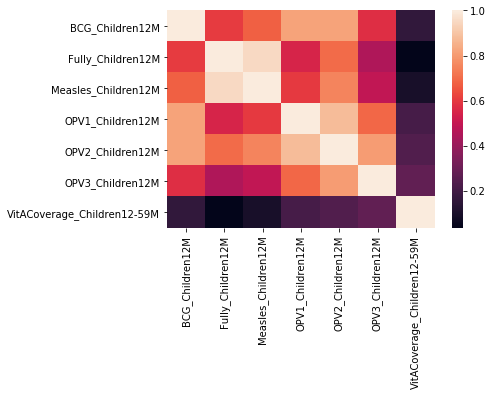

In [13]:
corr = immunisation_data.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [14]:
corr

,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M
BCG_Children12M,1.000000,0.605259,0.677672,0.820807,0.819138,0.575629,0.159252
Fully_Children12M,0.605259,1.000000,0.951351,0.550693,0.699842,0.451314,0.034248
Measles_Children12M,0.677672,0.951351,1.000000,0.601045,0.753993,0.492718,0.095400
OPV1_Children12M,0.820807,0.550693,0.601045,1.000000,0.882544,0.690786,0.215256
OPV2_Children12M,0.819138,0.699842,0.753993,0.882544,1.000000,0.805010,0.241107
OPV3_Children12M,0.575629,0.451314,0.492718,0.690786,0.805010,1.000000,0.277823
VitACoverage_Children12-59M,0.159252,0.034248,0.095400,0.215256,0.241107,0.277823,1.000000


In [15]:
for var in immunisation_data.columns:
    print(immunisation_data[var].isna().value_counts()/immunisation_data.shape[0])
immunisation_data = imput_missing(input_df=immunisation_data)  
for var in immunisation_data.columns:
    print(immunisation_data[var].isna().value_counts()/immunisation_data.shape[0])

False    1.0
Name: BCG_Children12M, dtype: float64
False    1.0
Name: Fully_Children12M, dtype: float64
False    1.0
Name: Measles_Children12M, dtype: float64
False    1.0
Name: OPV1_Children12M, dtype: float64
False    1.0
Name: OPV2_Children12M, dtype: float64
False    1.0
Name: OPV3_Children12M, dtype: float64
False    1.0
Name: VitACoverage_Children12-59M, dtype: float64
False    1.0
Name: geo, dtype: float64
False    1.0
Name: BCG_Children12M, dtype: float64
False    1.0
Name: Fully_Children12M, dtype: float64
False    1.0
Name: Measles_Children12M, dtype: float64
False    1.0
Name: OPV1_Children12M, dtype: float64
False    1.0
Name: OPV2_Children12M, dtype: float64
False    1.0
Name: OPV3_Children12M, dtype: float64
False    1.0
Name: VitACoverage_Children12-59M, dtype: float64
False    1.0
Name: geo, dtype: float64


### STEP 6: Fine tune and analyze the data and obtain the output of paramaters

In [16]:
immunisation_data.columns

Index(['BCG_Children12M', 'Fully_Children12M', 'Measles_Children12M',
       'OPV1_Children12M', 'OPV2_Children12M', 'OPV3_Children12M',
       'VitACoverage_Children12-59M', 'geo'],
      dtype='object')

In [17]:
immunisation_data.head()

,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,geo
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,4001
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2003
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,1004
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,1006
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,1009


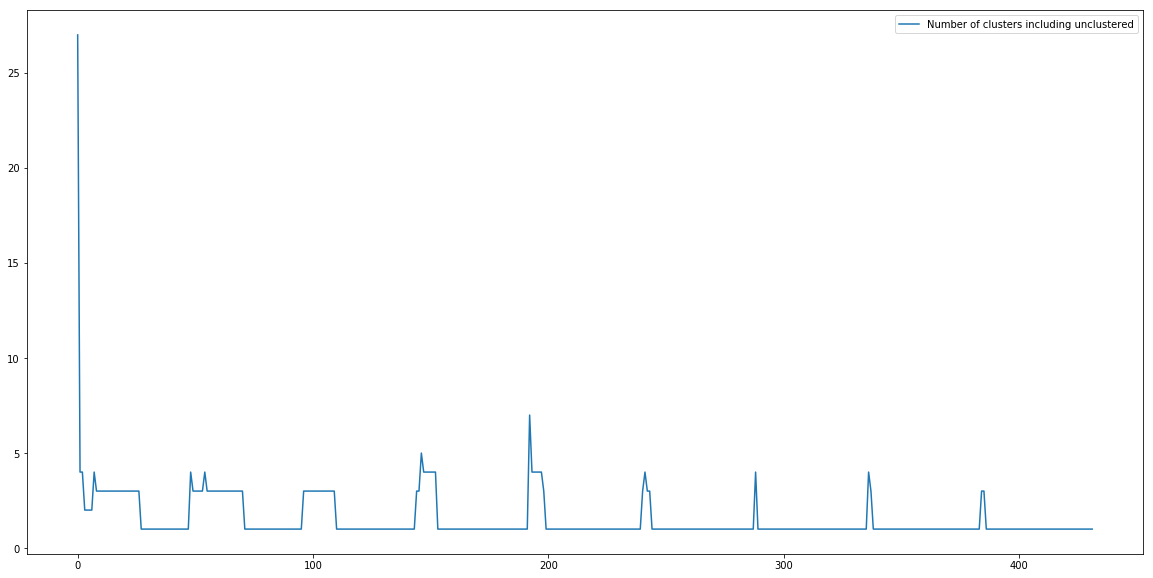

In [18]:
tmp, out = evaluate_hdbscan(input_df=immunisation_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='eom',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [19]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 10]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 3].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
1,1,3,4,2.34,88.28
2,1,4,4,2.34,88.28
48,2,2,4,4.69,88.28
7,1,9,4,35.94,35.16
54,2,8,4,41.41,33.59
146,4,4,5,65.62,15.62
149,4,7,4,68.75,15.62
148,4,6,4,68.75,15.62
147,4,5,4,68.75,15.62
150,4,8,4,68.75,15.62


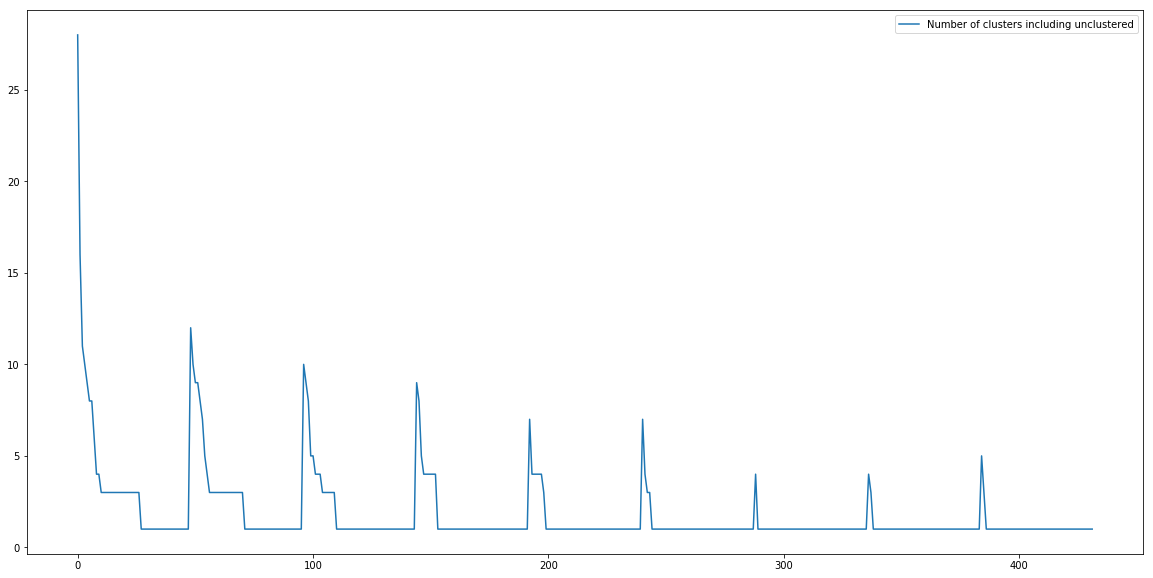

In [20]:
tmp, out = evaluate_hdbscan(input_df=immunisation_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='leaf',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [21]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 20]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 3].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
2,1,4,11,29.69,15.62
5,1,7,8,30.47,21.88
6,1,8,8,30.47,21.88
4,1,6,9,32.03,15.62
3,1,5,10,32.81,15.62
1,1,3,16,37.5,10.16
48,2,2,12,42.19,14.06
7,1,9,6,42.97,21.88
52,2,6,8,42.97,18.75
51,2,5,9,43.75,14.06


# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

## PART 2: Running the clustering
### STEP 1: Get files list

In [22]:
dfiles = get_files_list(input_dir=DATA)
dfiles = ['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2016.csv',
          '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/unicef/gdata/gdata_unicef_ces_2006.csv',]

### STEP 2: Read data

In [23]:
ddata = read_data(files_list=dfiles)
ddata = subset_vars(ddict=ddata)

Counter({True: 64, False: 24})
(64, 52)
Counter({True: 64, False: 13})
(64, 36)
Index(['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
       'FuzzRatio', 'Geo', 'Survey.Units', 'BCG_Children23M',
       'OPV1_Children23M', 'PENTA1_Children23M', 'OPV2_Children23M',
       'PENTA2_Children23M', 'OPV3_Children23M', 'PENTA3_Children23M',
       'Measles_Children23M', 'Fully_Children23M', 'BCG_Children12M',
       'OPV1_Children12M', 'PENTA1_Children12M', 'OPV2_Children12M',
       'PENTA2_Children12M', 'OPV3_Children12M', 'PENTA3_Children12M',
       'Measles_Children12M', 'Fully_Children12M',
       'DropoutPENTA1-PENTA3_Male23M', 'DropoutPENTA1-PENTA3_Female23M',
       'DropoutPENTA1-PENTA3_Children23M', 'DropoutPENTA1-Measles_Male23M',
       'DropoutPENTA1-Measles_Female23M', 'DropoutPENTA1-Measles_Children23M',
       'InvalidPENTA1_Infant12M', 'InvalidPENTA2_Infant12M',
       'InvalidPENTA3_Infant12M', 'InvalidMeasles_Infant12M',
       'Measles2ndDoseCrude', 'Meas

### STEP3: Check data 

In [24]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP4: Concat data 

In [25]:
ddf = concat_data1(ddict=ddata)
ddf['DistrictCode'] = ddf['DistrictCode'].astype(str)
ddf['DivisionCode'] = ddf['DivisionCode'].astype(str)
ddf['DistrictCode'] = ddf['DistrictCode'].str.pad(width=2, side='left', fillchar='0')
ddf['DivisionCode'] = ddf['DivisionCode'].str.pad(width=2, side='left', fillchar='0')
print(Counter([len(string) for string in ddf['DistrictCode']]))
print(Counter([len(string) for string in ddf['DivisionCode']]))
ddf['geo'] = ddf['DivisionCode'].str.cat(ddf['DistrictCode'])
display(ddf.head())
print(ddf.columns)
immunisation_drop = ['DistrictCode', 'DistrictName', 'DivisionCode', 'DivisionName',
                     'FuzzRatio', 'Geo', 'Survey.Units', ]
immunisation_data = ddf.drop(immunisation_drop, axis=1)
immunisation_data.head()

2016
2006
Counter({2: 128})
Counter({2: 128})


,BCG_Children12M,DistrictCode,DistrictName,DivisionCode,DivisionName,Fully_Children12M,FuzzRatio,Geo,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,Survey.Units,VitACoverage_Children12-59M,Year,geo
0,98.2,01,Bagerhat,40,Khulna,86.8,94,Bagerhat,90.3,97.4,96.8,90.8,Bagerhat 2016,82.0,2016,4001
1,99.0,03,Bandarban,20,Chittagong,80.9,95,Bandarban,86.3,96.3,94.8,87.8,Bandarban 2016,84.1,2016,2003
2,99.7,04,Barguna,10,Barisal,87.6,93,Barguna,91.0,98.8,97.9,93.0,Barguna 2016,96.8,2016,1004
3,99.7,06,Barisal,10,Barisal,91.0,93,Barisal,93.1,99.1,99.3,95.5,Barisal 2016,100.0,2016,1006
6,99.8,09,Bhola,10,Barisal,91.3,91,Bhola,95.4,99.8,99.8,94.5,Bhola 2016,98.4,2016,1009


Index(['BCG_Children12M', 'DistrictCode', 'DistrictName', 'DivisionCode',
       'DivisionName', 'Fully_Children12M', 'FuzzRatio', 'Geo',
       'Measles_Children12M', 'OPV1_Children12M', 'OPV2_Children12M',
       'OPV3_Children12M', 'Survey.Units', 'VitACoverage_Children12-59M',
       'Year', 'geo'],
      dtype='object')


,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,Year,geo
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,2016,4001
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2016,2003
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,2016,1004
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,2016,1006
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,2016,1009


In [26]:
immunisation_data.rename(columns={'Year':'year'}, inplace=True)
immunisation_data.head()

,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,year,geo
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,2016,4001
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2016,2003
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,2016,1004
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,2016,1006
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,2016,1009


### STEP 6: Create output dir

In [27]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


In [28]:
immunisation_data = imput_missing(input_df=immunisation_data)

## STEP 7: Clustering data and assigning collors

- Option 1: 
    - min_sample: 1
    - min_cluster_size: 9
    - clusters: 4
    - unclustered: 35.94%
    - max class: 35.16%			

In [29]:
print(immunisation_data.shape)
datad_option1 = cluster_data(input_df=immunisation_data, f_min_samples=1, f_min_cluster_size=9, cluster_selection_method='eom')
print(Counter(datad_option1['class']))
datad_option1, labs_cols = colors2clusters(df_input=datad_option1, cluster_var='class')
display(datad_option1.head())

(128, 9)
Index(['BCG_Children12M', 'Fully_Children12M', 'Measles_Children12M',
       'OPV1_Children12M', 'OPV2_Children12M', 'OPV3_Children12M',
       'VitACoverage_Children12-59M'],
      dtype='object')
Counter({-1: 46, 1: 45, 2: 28, 0: 9})
Counter({-1: 46, 1: 45, 2: 28, 0: 9})


,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,year,geo,class,colors
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,2016,4001,0,#1f78b4
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2016,2003,1,#b2df8a
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,2016,1004,1,#b2df8a
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,2016,1006,1,#b2df8a
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,2016,1009,1,#b2df8a


[2006]


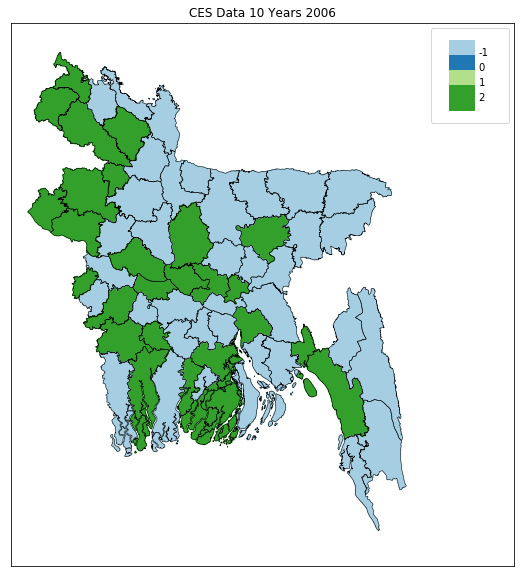

[2016]


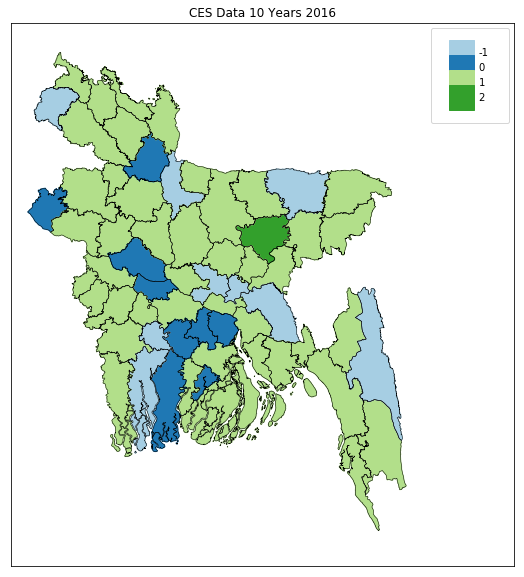

In [30]:
plot_clusters(input_df=datad_option1, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=PROJECT, output=OUTPUT)

- Option 2:
    - min_sample: 1
    - min_cluster_size: 7
    - clusters: 8
    - unclustered: 30.47%
    - max class: 21.88%	

In [31]:
print(immunisation_data.shape)
datad_option2 = cluster_data(input_df=immunisation_data, f_min_samples=1, f_min_cluster_size=7, cluster_selection_method='leaf')
print(Counter(datad_option2['class']))
datad_option2, labs_cols = colors2clusters(df_input=datad_option2, cluster_var='class')
display(datad_option2.head())

(128, 9)
Index(['BCG_Children12M', 'Fully_Children12M', 'Measles_Children12M',
       'OPV1_Children12M', 'OPV2_Children12M', 'OPV3_Children12M',
       'VitACoverage_Children12-59M'],
      dtype='object')
Counter({-1: 39, 3: 28, 5: 16, 6: 11, 1: 9, 4: 9, 0: 8, 2: 8})
Counter({-1: 39, 3: 28, 5: 16, 6: 11, 1: 9, 4: 9, 0: 8, 2: 8})


,BCG_Children12M,Fully_Children12M,Measles_Children12M,OPV1_Children12M,OPV2_Children12M,OPV3_Children12M,VitACoverage_Children12-59M,year,geo,class,colors
0,98.2,86.8,90.3,97.4,96.8,90.8,82.0,2016,4001,1,#b2df8a
1,99.0,80.9,86.3,96.3,94.8,87.8,84.1,2016,2003,-1,#a6cee3
2,99.7,87.6,91.0,98.8,97.9,93.0,96.8,2016,1004,5,#fdbf6f
3,99.7,91.0,93.1,99.1,99.3,95.5,100.0,2016,1006,-1,#a6cee3
6,99.8,91.3,95.4,99.8,99.8,94.5,98.4,2016,1009,-1,#a6cee3


### STEP 9: Getting statistics

In [32]:
output_table(input_df=datad_option1, out=OUTPUT, name='datad_option1')

['class', 'Fully_Children12M', 'Measles_Children12M', 'OPV3_Children12M', 'OPV2_Children12M', 'OPV1_Children12M', 'BCG_Children12M', 'VitACoverage_Children12-59M']


,Fully_Children12M,Measles_Children12M,OPV3_Children12M,OPV2_Children12M,OPV1_Children12M,BCG_Children12M,VitACoverage_Children12-59M
class,,,,,,,
-1,44.6 - 68.3 - 84.7,51.1 - 75.5 - 90.9,77.9 - 89.0 - 100.0,82.4 - 94.0 - 100.0,86.8 - 96.1 - 100.0,88.1 - 97.9 - 100.0,72.2 - 90.6 - 99.5
0,79.1 - 83.1 - 86.8,83.8 - 87.7 - 90.7,87.8 - 91.1 - 92.6,93.9 - 97.1 - 98.5,95.9 - 97.8 - 99.2,98.2 - 99.6 - 100.0,73.3 - 78.0 - 82.0
1,79.1 - 84.3 - 92.6,84.7 - 89.3 - 96.5,87.8 - 91.4 - 95.5,94.8 - 97.7 - 99.8,94.3 - 98.2 - 99.8,98.3 - 99.6 - 100.0,83.9 - 92.6 - 100.0
2,71.4 - 76.2 - 82.0,78.2 - 83.0 - 86.9,89.1 - 94.8 - 99.5,95.0 - 97.5 - 99.5,96.6 - 98.4 - 99.5,98.1 - 99.1 - 100.0,89.2 - 95.6 - 99.5


In [33]:
output_table(input_df=datad_option2, out=OUTPUT, name='datad_option2')

['class', 'Fully_Children12M', 'Measles_Children12M', 'OPV3_Children12M', 'OPV2_Children12M', 'OPV1_Children12M', 'BCG_Children12M', 'VitACoverage_Children12-59M']


,Fully_Children12M,Measles_Children12M,OPV3_Children12M,OPV2_Children12M,OPV1_Children12M,BCG_Children12M,VitACoverage_Children12-59M
class,,,,,,,
-1,56.3 - 74.2 - 91.3,64.7 - 81.5 - 95.4,80.1 - 90.5 - 100.0,91.0 - 96.1 - 100.0,93.4 - 97.2 - 100.0,94.3 - 99.1 - 100.0,72.2 - 91.4 - 100.0
0,44.6 - 55.6 - 64.5,51.1 - 62.6 - 70.7,77.9 - 80.8 - 83.2,82.4 - 85.9 - 88.4,86.8 - 91.1 - 95.2,88.1 - 93.3 - 97.6,82.0 - 86.9 - 89.8
1,79.1 - 83.1 - 86.8,83.8 - 87.7 - 90.7,87.8 - 91.1 - 92.6,93.9 - 97.1 - 98.5,95.9 - 97.8 - 99.2,98.2 - 99.6 - 100.0,73.3 - 78.0 - 82.0
2,67.2 - 70.1 - 74.7,72.5 - 75.6 - 79.4,90.3 - 92.0 - 94.3,93.6 - 95.9 - 98.1,94.7 - 97.6 - 99.5,97.1 - 98.4 - 99.5,90.7 - 94.1 - 95.9
3,71.4 - 76.2 - 82.0,78.2 - 83.0 - 86.9,89.1 - 94.8 - 99.5,95.0 - 97.5 - 99.5,96.6 - 98.4 - 99.5,98.1 - 99.1 - 100.0,89.2 - 95.6 - 99.5
4,85.8 - 88.3 - 92.6,89.0 - 92.4 - 96.5,91.0 - 93.8 - 95.2,97.8 - 98.7 - 99.6,98.1 - 99.0 - 99.8,99.4 - 99.8 - 100.0,86.8 - 89.9 - 92.7
5,79.6 - 83.4 - 87.6,84.7 - 88.4 - 91.9,88.9 - 91.2 - 93.1,97.2 - 98.0 - 99.2,97.4 - 98.5 - 99.4,99.2 - 99.8 - 100.0,93.6 - 96.3 - 99.4
6,79.1 - 82.4 - 84.4,85.6 - 87.6 - 91.4,88.0 - 89.9 - 91.4,95.3 - 96.5 - 97.3,94.8 - 97.3 - 99.0,98.3 - 99.3 - 100.0,85.4 - 88.6 - 91.7


In [37]:
clusters = output_class(input_df=datad_option1)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.to_csv(OUTPUT+"/clusters_paths_option1.csv", index=False, index_label=False)
display(clusters.sort_values([2006,2016], ascending=False).head(32))
display(clusters.sort_values([2006,2016], ascending=False).tail(32))


,geo,2006,2016,geo,dv,Div_Name,zl,Zila_Name2
28,3048,2,2,3048,30,Dhaka,48,Kishoreganj
2,1004,2,1,1004,10,Barisal,04,Barguna
3,1006,2,1,1006,10,Barisal,06,Barishal
7,2013,2,1,2013,20,Chittagong,13,Chandpur
9,2015,2,1,2015,20,Chittagong,15,Chattogram
14,5527,2,1,5527,55,Rangpur,27,Dinajpur
16,2030,2,1,2030,20,Chittagong,30,Feni
22,4041,2,1,4041,40,Khulna,41,Jashore
24,4044,2,1,4044,40,Khulna,44,Jhenaidaha
25,5038,2,1,5038,50,Rajshahi,38,Joypurhat


,geo,2006,2016,geo,dv,Div_Name,zl,Zila_Name2
12,2022,-1,1,2022,20,Chittagong,22,Coxs Bazar
15,3029,-1,1,3029,30,Dhaka,29,Faridpur
18,3033,-1,1,3033,30,Dhaka,33,Gazipur
20,6036,-1,1,6036,60,Sylhet,36,Habiganj
26,2046,-1,1,2046,20,Chittagong,46,Khagrachhari
29,5549,-1,1,5549,55,Rangpur,49,Kurigram
30,4050,-1,1,4050,40,Khulna,50,Kustia
31,2051,-1,1,2051,20,Chittagong,51,Laksmipur
32,5552,-1,1,5552,55,Rangpur,52,Lalmonirhat
34,4055,-1,1,4055,40,Khulna,55,Magura


In [35]:
clusters = output_class(input_df=datad_option2)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.to_csv(OUTPUT+"/clusters_paths_option2.csv", index=False, index_label=False)
clusters.sort_values([2006,2016], ascending=False).head()


,geo,2006,2016,geo,dv,Div_Name,zl,Zila_Name2
36,4057,3,6,4057,40,Khulna,57,Meherpur
49,5577,3,6,5577,55,Rangpur,77,Panchagarh
50,1078,3,6,1078,10,Barisal,78,Patuakhali
62,3093,3,6,3093,30,Dhaka,93,Tangail
2,1004,3,5,1004,10,Barisal,04,Barguna


### STEP 8: Plotting clusters: datad_option1